# Transfer learning 

Каждый раз, обучая нейронку, мы сначала рандомно инициализируем веса, а после в ходе бэкпропа обучаем модель. Если мы сразу же угадываем хорошие веса, модель сходится быстрее. Иногда можно брать в качестве инициализации веса, полученные другими исследователями и на их основе дообучать модель под свой выход. Это здорово упрощает задачу обучения и экономит недели работы.

Transfer learning это когда ты берёшь чужую модель и адаптируешь её под свою задачу. В этой тетрадке мы  посмотрим на то, как в tensorflow можно этим заняться.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


# 1. Реквизируем MobileNet 

Мы обсуждали то, как люди Imagenet рвали. В ходе этого обсуждения мы посмотрели на многие модные архитектуры. В самом конце мы сказали, что добившись высокого качества, Google решил, что надо бы сделать свои сетки более компактными, чтобы они влазили в мобилу. Одним из результатов этой работы стало создание [архитектуры MobileNetV2.](https://arxiv.org/abs/1801.04381) Она была собрана и обучена на ImageNet в апреле 2018 года. Если говорить грубо, MobileNet это почти как Inception, но меньше. 

In [2]:
import requests
import tensorflow.keras.applications as zoo  

Давайте возьмём предобученную модель из Keras и просто попробуем её для чего-нибудь поиспользовать. 

In [3]:
model = zoo.MobileNetV2(include_top=True, weights='imagenet')

14548992/14536120 [==============================] - 0s 0us/step


Опция `weights` отвечает за то, на каком датасете предобучена модель. Опция `include_top` отвечает за то, скачиваем мы модель полностью или только `feature extractor`, то есть только первые слои. Мы скачали всё. 

In [4]:
# Узнаем размерность входа и выхода
input_shape = model.layers[0].output_shape[0][1:3]
input_shape

(224, 224)

Теперь попробуем что-нибудь спрогнозировать. В модуле `keras.utis` есть функция `get_file`, которая умеет скачивать и разархивировать разные файлы. Будем использовать её для скачки картинок по ссылкам. 

In [5]:
from tensorflow.keras.utils import get_file

131072/120478 [================================] - 0s 0us/step
/root/.keras/datasets/cat.jpg


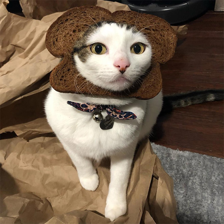

In [6]:
import PIL.Image
import numpy as np

href = 'https://sadanduseless.b-cdn.net/wp-content/uploads/2019/06/cat-breading4.jpg'
image = get_file('cat.jpg', href)

print(image) # куда скачался то?! 

image = PIL.Image.open(image).resize(input_shape)
image 

In [7]:
# немного предобработки
image = np.array(image)/255.0
image.shape

(224, 224, 3)

In [8]:
# вот так можно добавить фиктивную размерность
image[np.newaxis, :,:,:].shape

(1, 224, 224, 3)

In [9]:
# строим прогноз 
result = model.predict(image[np.newaxis, :,:,:])
result.shape

(1, 1000)

Готово! У нас есть $1000$ вариантов прогноза. Если быть более конкретным, нас в случае данного изображения устраивает класс номер

In [10]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

452

In [11]:
result[0].argsort()[-5:][::-1] # топ-5 классов

array([452, 285, 281, 728, 588])

Осталось только выяснить что это за класс. Для этого нам нужны метки Imagenet. Скачаем их. Они тоже уже есть в пакете. Удобно. 

In [12]:
from tensorflow.python.keras.applications.vgg16 import decode_predictions
decode_predictions(result)[0]

40960/35363 [==================================] - 0s 0us/step


[('n02869837', 'bonnet', 0.07289744),
 ('n02124075', 'Egyptian_cat', 0.062185023),
 ('n02123045', 'tabby', 0.05512909),
 ('n03958227', 'plastic_bag', 0.049501944),
 ('n03482405', 'hamper', 0.044322442)]

Напишем функцию для строительства прогнозов и попробуем ещё. 

In [13]:
import matplotlib.pyplot as plt

def save_image(href, save_name):
    img = get_file(save_name, href)
    return img
    
def predict(image_path):
    # Подгружаем изображение и делаем его ресайз в соответсвии с моделью
    img = PIL.Image.open(image_path)
    
    # тут чуть подрбнее про ресайзы: https://habr.com/ru/post/247219/
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Рисуем картинку
    plt.imshow(img_resized)
    plt.show()

    # Кнвертируем картинку в numpy и делаем лишнюю размерность
    img_array = np.array(img_resized)[np.newaxis, ...]

    # VGG-16 строит нам прогноз
    pred = model.predict(img_array)
    
    # Декодируем прогноз
    pred_decoded = decode_predictions(pred)[0]

    # Печатаем его на экран
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

229376/220563 [===============================] - 0s 0us/step


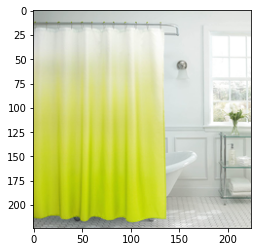

69.66% : shower_curtain
 5.56% : window_shade
 4.31% : pillow
 1.83% : slot
 1.38% : window_screen


In [14]:
href = 'https://images-na.ssl-images-amazon.com/images/I/91NKh-FPcBL._SL1500_.jpg'
path = save_image(href, 'shower_curtain.jpg')
predict(path)

In [15]:
from keras.preprocessing.image import load_img

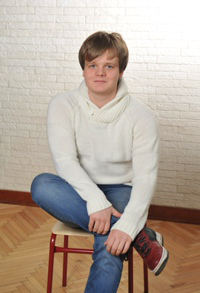

In [16]:
load_img('Vlad.jpg')

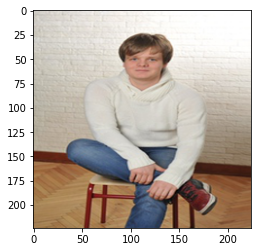

26.72% : shower_curtain
18.08% : pillow
 6.98% : maze
 4.65% : fire_screen
 3.43% : envelope


In [17]:
# href = 'https://sun9-34.userapi.com/c850216/v850216669/110118/s1XSv_XLgtY.jpg'
# path = save_image(href, 'the_most_awesome_boy.jpg')
predict('Vlad.jpg')

__Последняя картинка как-то исказилась.__  Когда мы делаем `.resize`, мы используем опцию `PIL.Image.LANCZOS` она делает кое-какие приятные ништяки, связанные с защитой изображения от искажений. Вообще борьба с искажениями и разными размерностями у картинок - один из этапов предобработки. 

Как добиться того, чтобы картинка не искажалась? Использовать какие-то похожие фильры, либо обрезать картинки. Давайте попробуем написать в numpy функцию, которая будет заниматься обрезанием картинок вот по такой схеме: 

<img src="https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/week3/images/center_crop.jpg" style="width:50%">

Попробуйте самостоятельно сделать её.

In [18]:
# Функция для обрезания картинок 
def image_center_crop(img):
    w = img.shape[0]
    h = img.shape[1]
    if w > h :
        cropped_img = img[(w-h)//2:w-(w-h)//2,:,:]
    elif w < h:
        cropped_img = img[:,(h-w)//2:h-(h-w)//2,:]
    else:
        cropped_img = img
    return cropped_img

Вставим эту функцию в построение прогнозов. 

In [19]:
def predict(image_path):
    # Подгружаем изображение и делаем его ресайз в соответсвии с моделью
    img = PIL.Image.open(image_path)
    
    # переделали в массив, обрезали 
    img = image_center_crop(np.array(img)) 
    
    # вернули назад в картинку, сделали resize 
    img_resized = PIL.Image.fromarray(img).resize(input_shape)

    # Рисуем картинку
    plt.imshow(img_resized)
    plt.show()

    # Кнвертируем картинку в numpy и делаем лишнюю размерность
    img_array = np.array(img_resized)[np.newaxis, ...]

    # VGG-16 строит нам прогноз
    pred = model.predict(img_array)
    
    # Декодируем прогноз
    pred_decoded = decode_predictions(pred)[0]

    # Печатаем его на экран
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

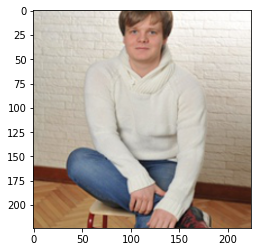

45.73% : fire_screen
12.78% : shower_curtain
 4.39% : lampshade
 3.39% : maze
 2.55% : window_screen


In [20]:
predict('Vlad.jpg')

В `ImageNet` нет людей. Поэтому можно попробовать выяснить на кого именно ты сильнее всего похож. Чаще всего это будет либо подушка либо занавеска. Если выпадает что-то другое, тебе крупно повезло. 

In [ ]:
########################
# Твой код с картинкой
########################

# 2. Transfer learning 

Побаловались с прогнозами, теперь давайте займёмся более серьёзными проблемами. Например, попробуем решить проблему тысячелетия вслед за [лучшими китайскими учёными.](https://www.youtube.com/watch?v=vIci3C4JkL0)


![](https://www.semantics3.com/blog/content/images/downloaded_images/hot-dog-and-a-not-hot-dog-the-distinction-matters-code-included-8550067fb16/1-VrpXE1hE4rO1roK0laOd7g.png)


По мотивам этой великой проблемы даже сделали [соревнование на kaggle.](https://www.kaggle.com/c/hotdogornot)  Но да ладно. Давайте лучше скачаем [папку с картинками](https://yadi.sk/d/AJra6kvvWV77nA) и приступим к работе. 

## 2.1 Данные 

Для начала попробуем применить нашу модель и посмотреть что будет происходить.

In [22]:
!unzip train.zip
data_root = "train/"

Archive:  train.zip
   creating: train/
  inflating: __MACOSX/._train        
  inflating: train/.DS_Store         
  inflating: __MACOSX/train/._.DS_Store  
   creating: train/pets/
  inflating: __MACOSX/train/._pets   
   creating: train/frankfurter/
  inflating: __MACOSX/train/._frankfurter  
   creating: train/furniture/
  inflating: __MACOSX/train/._furniture  
   creating: train/hotdog/
  inflating: __MACOSX/train/._hotdog  
   creating: train/chili-dog/
  inflating: __MACOSX/train/._chili-dog  
   creating: train/people/
  inflating: __MACOSX/train/._people  
   creating: train/food/
  inflating: __MACOSX/train/._food   
  inflating: train/pets/pets_19.jpg  
  inflating: __MACOSX/train/pets/._pets_19.jpg  
  inflating: train/pets/pets_31.jpg  
  inflating: __MACOSX/train/pets/._pets_31.jpg  
  inflating: train/pets/pets_30.jpg  
  inflating: __MACOSX/train/pets/._pets_30.jpg  
  inflating: train/pets/pets_24.jpg  
  inflating: __MACOSX/train/pets/._pets_24.jpg  
  inflating: tra

Забивать оперативную память лишними гигабайтами картинок не очень хочется, поэтому мы будем считывать картинки с жёсткого диска. Напишем для этого генератор, который будет считывать картинки по одной. 

In [23]:
# идём в керасовский модуль и берём из него функцию для генератора
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

# внутри генератора есть очень широкие возможности для аугментации, на них вы посмотрите в дз
image_generator = ImageDataGenerator(rescale=1/255)

# натравливаем гинератор на конкретную директорию c данными
image_data = image_generator.flow_from_directory(data_root, 
                                                 batch_size=32,           # размер батча
                                                 target_size=input_shape  # размер входных данных для сетки
                                                )

Found 555 images belonging to 7 classes.


Посмотрим на характеристики батчей, которые лежат внутри генератора. 

In [24]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Labe batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 7)


Можно посмотреть на число шагов, которое собрался делать генератор. 

In [25]:
image_data.n

555

А ещё на названия классов. 

In [26]:
image_data.class_indices.keys()

dict_keys(['chili-dog', 'food', 'frankfurter', 'furniture', 'hotdog', 'people', 'pets'])

Давайте прогоним текущий батч через нейронку и посмотрим на прогнозы. 

In [27]:
# построим прогнозы по батчу из картинок
result_batch = model.predict(image_batch)

In [28]:
# что там у нас спрогнозировалось? 
labels_batch = [item[0] for item in decode_predictions(result_batch)]

Посмотрим на  картинки и построенные по ним прогнозы. 

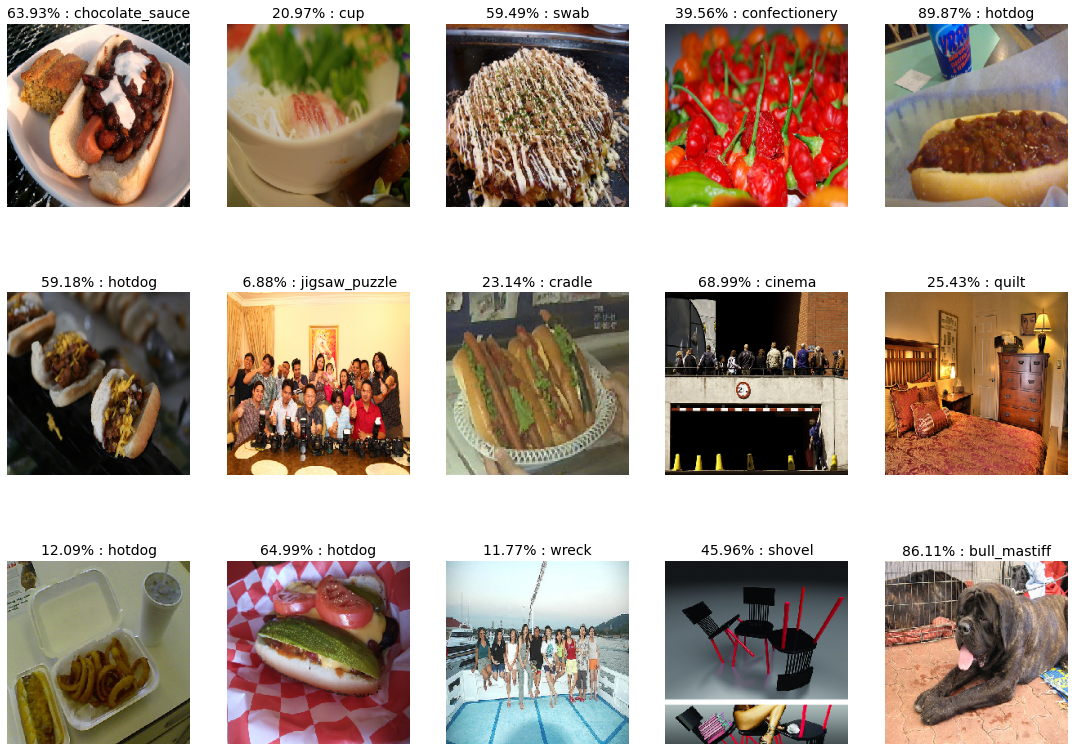

In [29]:
cols = 5
rows = 3
fig = plt.figure(figsize=(4 * cols - 1, 5 * rows - 1))

k = 0 
for i in range(cols):
    for j in range(rows):
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(image_batch[k])
        ax.set_title("{0:>6.2%} : {1}".format(labels_batch[k][2], labels_batch[k][1]), size=14)
        k += 1
plt.show()

Модель отрабатывает на уровне выше всех похвал (но это неточно).

## 2.2 Дообучаем сетку

Предобученная сетка не приспособлена для работы с нашими классами. Давайте заставим её их выучить. Для этого нам придётся срезать с сетки её последние слои. Посмотрим на `summary` модели. 

In [71]:
base_model = zoo.MobileNetV2(include_top=False, weights='imagenet')

In [72]:
 base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, None, None, 3 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [99]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten
# Freeze the base model
base_model.trainable = False

# Use a Sequential model to add a trainable classifier on top
model = Sequential([
    base_model,
    Flatten(),
    Dense(7, activation='softmax'),
])

Посмотрим на то, какие слои собрались обучаться. Но сначала прогоним модель для ее сборки.

In [100]:
result = model.predict(image_batch)
result.shape

(32, 7)

In [101]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_471 (ModuleWr (32, 7, 7, 1280)          2257984   
_________________________________________________________________
flatten (Flatten)            (32, 62720)               0         
_________________________________________________________________
dense_9 (Dense)              (32, 7)                   439047    
Total params: 2,697,031
Trainable params: 439,047
Non-trainable params: 2,257,984
_________________________________________________________________


Теперь наконец мы можем скомпилировать модель.  Оптимизировать всё это чудо будет нами горячо любимый Adam.  Каждую эпоху (полный проход по данным) в ходе алгоритма обратного распространения ошибки, мы будем обучать только последние слои. Одна эпохо в данном случае - проход по всем картинкам из наших папочек. Будем учить сетку $5$ эпох. 

In [102]:
model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['acc']
)

# число шагов до конца первой эпохи
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

# учим сетку одну эпоху
model.fit(image_data, epochs=5, 
            steps_per_epoch = steps_per_epoch)

Epoch 1/5
18/18 [==============================] - 21s 959ms/step - loss: 3.5643 - acc: 0.5315
Epoch 2/5
18/18 [==============================] - 17s 955ms/step - loss: 0.6035 - acc: 0.9207
Epoch 3/5
18/18 [==============================] - 17s 952ms/step - loss: 0.3014 - acc: 0.9477
Epoch 4/5
18/18 [==============================] - 17s 957ms/step - loss: 0.1523 - acc: 0.9802
Epoch 5/5
18/18 [==============================] - 18s 962ms/step - loss: 0.1685 - acc: 0.9820


Давайте посмотрим на текущие прогнозы сетки. 

In [108]:
# построим прогнозы по батчу из картинок
result_batch = model.predict(image_batch)

In [109]:
result_batch.shape

(32, 7)

In [110]:
classes = list(image_data.class_indices.keys())
classes

['chili-dog', 'food', 'frankfurter', 'furniture', 'hotdog', 'people', 'pets']

In [111]:
np.argmax(result_batch, axis=1)

array([0, 1, 1, 1, 0, 0, 5, 2, 5, 3, 0, 0, 5, 3, 6, 2, 1, 5, 4, 1, 2, 2,
       1, 4, 3, 6, 5, 6, 1, 2, 2, 3])

In [112]:
labels_batch = [classes[i] for i in np.argmax(result_batch, axis=1)]
labels_batch[:10]

['chili-dog',
 'food',
 'food',
 'food',
 'chili-dog',
 'chili-dog',
 'people',
 'frankfurter',
 'people',
 'furniture']

In [113]:
labels_batch = list(zip(np.max(result_batch, axis=1), labels_batch))
labels_batch[:10]

[(1.0, 'chili-dog'),
 (1.0, 'food'),
 (1.0, 'food'),
 (1.0, 'food'),
 (1.0, 'chili-dog'),
 (1.0, 'chili-dog'),
 (1.0, 'people'),
 (1.0, 'frankfurter'),
 (1.0, 'people'),
 (1.0, 'furniture')]

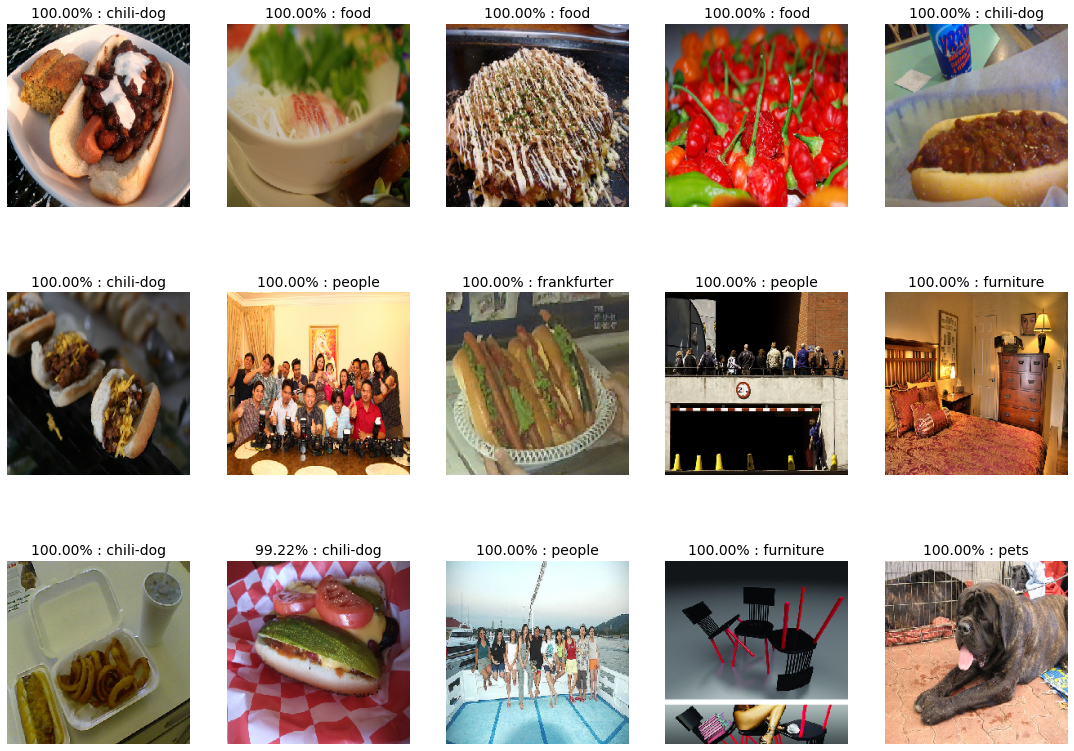

In [114]:
cols = 5
rows = 3
fig = plt.figure(figsize=(4 * cols - 1, 5 * rows - 1))

k = 0 
for i in range(cols):
    for j in range(rows):
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(image_batch[k])
        ax.set_title("{0:>6.2%} : {1}".format(labels_batch[k][0], labels_batch[k][1]), size=14)
        k += 1
plt.show()

Явно стало лучше :) 

# 3. Tensor hub 

В $2017$ году Google сделал специальную платформу __TensorFlow Hub.__  Она используется для того, чтобы делиться друг с другом моделями. В таком формате свои результаты сохраняют различные исслодовательские группы. В том числе Россияская группа IPavlov. В следующие разы мы будем воровать у них модели через эту библиотечку.  

Сейчас давайте посмотрим как это делается. Для начала нужно установить `tensorflow_hub` на свой компьютер через __pip.__

In [117]:
import tensorflow as tf
import tensorflow_hub as hub

print(tf.__version__)
print(hub.__version__)

2.6.0
0.12.0


## 3.1 Собираем модель

По [ссылке](https://tfhub.dev) можно найти зоопарк моделей от Google для открытого использования через библиотеку. Мы выберем среди всего этого огромного числа моделек архитектуру [MobileNetV2,](https://arxiv.org/abs/1801.04381) обученную Google в апреле 2018 года на ImageNet. Эта сетка - развитие Inception. Подробнее про неё можно почитать либо в [оригинальной статье,](https://arxiv.org/abs/1801.04381) либо [на Хабре.](https://habr.com/ru/post/352804/)

Сетка подгружается библиотекое tensorflow_hub просто по ссылке.

In [118]:
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 
hub_module =  hub.load(url)

 Дальше мы можем завернуть её в удобную функцию и начать применять. 

In [119]:
IMAGE_SHAPE = [224, 224]

classifier = tf.keras.Sequential([
    hub.KerasLayer(url, input_shape=IMAGE_SHAPE+[3])
])

In [120]:
# input shape такой, потому что три канала
IMAGE_SHAPE + [3]

[224, 224, 3]

In [121]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


Запустим сетку на изображении. 

In [122]:
href = 'https://sadanduseless.b-cdn.net/wp-content/uploads/2019/06/cat-breading4.jpg'
image = get_file('cat.jpg', href)

print(image) # куда скачался то?! 

image = PIL.Image.open(image).resize(input_shape)
image = np.array(image)/255

classifier.predict(image[np.newaxis, ...])

/root/.keras/datasets/cat.jpg


array([[ 0.12381479, -0.7201814 , -0.13566488, ..., -0.96592265,
         0.21174797,  2.1669667 ]], dtype=float32)

При желании можно узнать что за класс получился на выходе по аналогии с тем, как мы сделали это в самом начале тетрадки.

## 3.2 Дообучаем сетку

Доучивать её мы будем на тех же самых данных по хотдогам. 

In [123]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 7)


Нам для дообучения понадобится только feature extractor, его мы и скачаем.

In [124]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

Посмотрим что будет идти из этого экстрактора на выход. 

In [125]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


Запретим tensorflow тренировать веса экстрактора.

In [126]:
feature_extractor_layer.trainable = False

Cобираем модель, на последний слой вытаскиваем softmax на 7 классов


In [127]:
image_data.num_classes

7

In [128]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 7)                 8967      
Total params: 2,266,951
Trainable params: 8,967
Non-trainable params: 2,257,984
_________________________________________________________________


In [129]:
# проверяем запускается ли модель, которую мы собрали и что она выдаёт на выходе
result = model.predict(image_batch)
result.shape

(32, 7)

Собираем модель и запускаем обучение.

In [130]:
model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss='categorical_crossentropy',
      metrics=['acc']
)

# число шагов до конца первой эпохи
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

# учим сетку одну эпоху
model.fit(image_data, epochs=3, 
            steps_per_epoch = steps_per_epoch)

Epoch 1/3
18/18 [==============================] - 20s 916ms/step - loss: 1.5856 - acc: 0.3748
Epoch 2/3
18/18 [==============================] - 17s 913ms/step - loss: 0.8605 - acc: 0.7081
Epoch 3/3
18/18 [==============================] - 17s 924ms/step - loss: 0.6296 - acc: 0.7964


По аналогии с кодом выше можно посмотреть что наша модель будет прогнозировать. Лучше сделаем другую вещь. Мы довольно долго учили модельку. Давайте её сохраним на компьютер. 

In [131]:
export_path = tf.keras.models.save_model(model, "saved_models")
export_path

INFO:tensorflow:Assets written to: saved_models/assets


INFO:tensorflow:Assets written to: saved_models/assets


In [132]:
new_model = tf.keras.models.load_model('saved_models')

In [133]:
# построим прогнозы по батчу из картинок
result_batch = new_model.predict(image_batch)
labels_batch = [classes[i] for i in np.argmax(result_batch, axis=1)]
labels_batch[:10]

['food',
 'hotdog',
 'frankfurter',
 'frankfurter',
 'people',
 'furniture',
 'people',
 'furniture',
 'people',
 'chili-dog']

In [134]:
labels_batch = list(zip(np.max(result_batch, axis=1), labels_batch))
labels_batch[:10]

[(0.8288666, 'food'),
 (0.7168682, 'hotdog'),
 (0.60566235, 'frankfurter'),
 (0.74622184, 'frankfurter'),
 (0.91160524, 'people'),
 (0.79918873, 'furniture'),
 (0.9702426, 'people'),
 (0.9642941, 'furniture'),
 (0.9658433, 'people'),
 (0.4094622, 'chili-dog')]

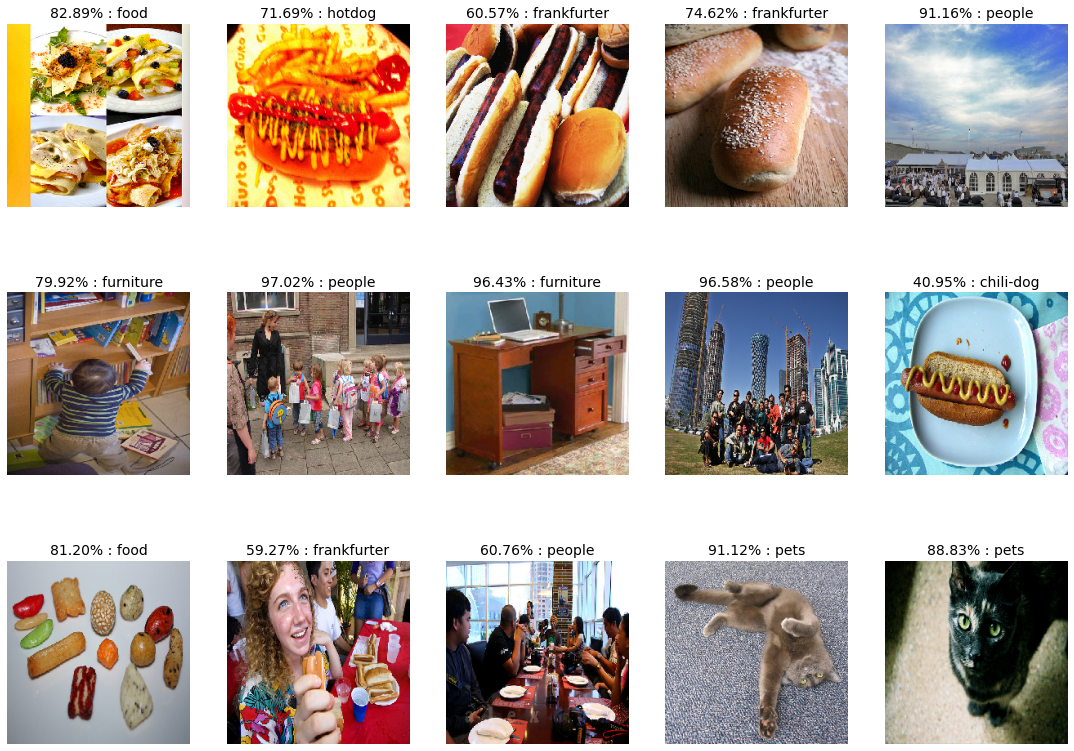

In [135]:
cols = 5
rows = 3
fig = plt.figure(figsize=(4 * cols - 1, 5 * rows - 1))

k = 0 
for i in range(cols):
    for j in range(rows):
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(image_batch[k])
        ax.set_title("{0:>6.2%} : {1}".format(labels_batch[k][0], labels_batch[k][1]), size=14)
        k += 1
plt.show()

Обратите внимание, что мы здесь не дробили выборку на трэйн и тест, а просто дообучали сетку сразу и на всём. Делали мы это для того, чтобы тетрадка выглядела попроще.  


## Почиташки 

Делал этут тетрадку на основе двух туториалов: 

* [Первый,](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/10_Fine-Tuning.ipynb)  на этом гитхабе довольно большое количество крутых тетрадок про нейронки. Рекомендую позалипать на них. 
* [Документация Tensorflow_Hub](https://www.tensorflow.org/hub) и [пример](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) её применения на цветочках
* [Пример извлечения фичей для SWM из нейронки,](https://www.kaggle.com/craigglastonbury/using-inceptionv3-features-svm-classifier) если вдруг это кого-то заинтересовало.